In [1]:
import os
import glob
import json
import pandas as pd
import log_codes as log
import log_print_functions as log_print
from datetime import datetime, date, time

directory_path = './logs/dut0_ecc_bypass/logs_client'
file_pattern = 'Client_dut*'

# Use glob to find all files matching the pattern
file_paths = glob.glob(os.path.join(directory_path, file_pattern))

def parse_files(file_paths):
    frames = []
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            for json_line in file:
                # Parse frame
                try:
                    frame = json.loads(json_line)
                except Exception as error:
                    print(f"Failed decoding JSON for file {file_path}: {error}")
                frames.append(frame)
    return frames

frames_original = sorted(parse_files(file_paths), key=lambda x: x["timestamp"])
raw_df = pd.DataFrame(frames_original)

### Converting Unix timestamp to UTC

And droping any duplicates.... Why do we do this though?????

In [2]:
raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'], unit='s').dt.tz_localize('UTC')
# raw_df = raw_df.drop_duplicates()
raw_df

,message,type,id,timestamp,data,event
0,,Serial dut0_monitor,20,2023-12-07 09:07:12.956664320+00:00,aa013c00000000e243ef10b2745fb20000000000000000...,NaN
1,,Serial dut0_monitor,20,2023-12-07 09:07:18.652269056+00:00,aa013c00000000d143ef10248560b40000000000000000...,NaN
2,,Serial dut0_monitor,20,2023-12-07 09:07:24.355120384+00:00,aa013c00000000da43ef10969561b60000000000000000...,NaN
3,,Serial dut0_monitor,20,2023-12-07 09:07:30.049235712+00:00,aa013c00000000da43ef1008a662b80000000000000000...,NaN
4,,Serial dut0_monitor,20,2023-12-07 09:07:35.752018176+00:00,aa013c00000000d843ef107ab663ba0000000000000000...,NaN
...,...,...,...,...,...,...
12390,,Serial dut0_monitor,20,2023-12-08 17:06:54.042801920+00:00,aa013c00000000e243ef10789ae89a5054060000000000...,NaN
12391,,Serial dut0_monitor,20,2023-12-08 17:06:59.743069952+00:00,aa013c00000000c243ef10eaaae99c4f54060000000000...,NaN
12392,,Serial dut0_monitor,20,2023-12-08 17:07:05.437579008+00:00,aa013c00000000e343ef105cbbea9e4f54060000000000...,NaN
12393,,Serial dut0_monitor,20,2023-12-08 17:07:11.133814016+00:00,aa013c00000000d543ef10cecbeba04f54060000000000...,NaN


## Custom frame decoding

In ```log_codes.py``` you can create the dictionary that holds the frame formatting for a given frame ID. This will be custom to your specific frame. Find the documentation for each field in payload_parser. 

Also define the keys for each element.

Now, parse the fields based on frame type and then parsing the data tuple into readable fields


In [3]:

# Parse raw frame into executions
execution_df = log.parse_data(raw_df)
try:
    execution_df['timestamp'] = pd.to_datetime(execution_df['timestamp']).dt.tz_localize('UTC')
except Exception as error:
    print(f"Error converting timestamp to datetime: {error}")

execution_df[814:817]


,event,timestamp,total_errors,mcycle,minstret,imem_se,imem_de,dmem_se,dmem_de,regfile_se,regfile_de,iv,jump,branch,dsp_t,trap,illegal
814,1,2023-12-07 10:27:59.130377472+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
815,5,2023-12-07 10:28:05.841441536+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
816,1,2023-12-07 10:28:12.935265024+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Separate into runs

Now that we have the events correctly embedded in the data, we separate the runs according to events.

Each timeout event generates a discontinuity in the data. Each discontinuity is a new run. We remove runs that are composed only of events. 

In [4]:

list_of_runs = []
start_index = 0
for index, row in execution_df.iterrows():
    if row['event'] == log.ERROR_TIMEOUT:
        sliced_df = execution_df[start_index:index]
        list_of_runs.append(sliced_df)
        start_index = index
sliced_df = execution_df[start_index:]
list_of_runs.append(sliced_df)

# Remove invalid runs
list_of_runs = [df for df in list_of_runs if not all(df['event'] != 0)]

# Remove timeout from run slice
for i in range(len(list_of_runs)):
    if len(list_of_runs[i]) > 0 and list_of_runs[i].iloc[0]['event'] == 5:
        list_of_runs[i] = list_of_runs[i].iloc[1:]

#Number of runs
print(f"Number of valid runs = {len(list_of_runs)}")
list_of_runs[6]

Number of valid runs = 22


,event,timestamp,total_errors,mcycle,minstret,imem_se,imem_de,dmem_se,dmem_de,regfile_se,regfile_de,iv,jump,branch,dsp_t,trap,illegal
816,1,2023-12-07 10:28:12.935265024+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
817,0,2023-12-07 10:28:18.838526208+00:00,0,284115948,33628378,0,0,0,0,0,0,0,1062528,2449585,0,3,0
818,0,2023-12-07 10:28:24.541421824+00:00,0,284115921,67252556,0,0,0,0,0,0,0,1062528,2449585,0,3,0
819,0,2023-12-07 10:28:30.236093952+00:00,0,284115924,100876734,0,0,0,0,0,0,0,1062528,2449585,0,3,0


In [5]:
# filtered_df = list_of_runs[-1][list_of_runs[-1]['timestamp'].dt.hour >= 15]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.hour < 16]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.minute >= 0]
# filtered_df = filtered_df[filtered_df['timestamp'].dt.minute <=58]


filtered_df = list_of_runs[-1].loc[:, ['timestamp', 'imem_se', 'imem_de', 'dmem_se', 'dsp_t', 'iv']]
filtered_df = filtered_df.drop_duplicates(subset=filtered_df.columns.difference(['timestamp']))
filtered_df


# filtered_df

,timestamp,imem_se,imem_de,dmem_se,dsp_t,iv
10514,2023-12-08 10:43:38.403195392+00:00,0,0,0,0,0
10539,2023-12-08 10:46:00.990797056+00:00,0,0,271,0,0
10573,2023-12-08 10:49:14.621340160+00:00,11,0,0,0,0
10574,2023-12-08 10:49:20.315795200+00:00,60,0,0,0,0
10576,2023-12-08 10:49:31.705049088+00:00,60,0,132,0,0
...,...,...,...,...,...,...
12338,2023-12-08 17:01:57.822300416+00:00,399440,0,0,0,113315
12341,2023-12-08 17:02:14.913328896+00:00,399439,0,324,0,113315
12363,2023-12-08 17:04:20.242692608+00:00,403535,0,0,0,113315
12364,2023-12-08 17:04:25.938018560+00:00,414799,0,0,0,113315


-------------

# Data Analysis

Using ```list_of_runs``` as input

### Timestamps and totals for each run

Get start, end, and total number of errors for each run

In [6]:
index = 0

for df in list_of_runs:
    start = df.iloc[0]['timestamp']
    end = df.iloc[-1]['timestamp']
    total_time = end - start
    total_imem_de = df['imem_de'].sum()
    total_dsp_t = df['dsp_t'].sum()
    total_errors = df['total_errors'].sum()
    # total_errors = df['imem_se'].sum()
    # print(start.hour)

    
    if start.hour > 10 or (start.hour >= 10 and start.minute >= 30):
        start_str = start.strftime("%d %H:%M:%S.%f")[:-3]  # Limit seconds to 2 decimal places
        end_str = end.strftime("%H:%M:%S.%f")[:-3]  # Limit seconds to 2 decimal places
        duration = round((end - start).total_seconds(), 1)  # Limit duration to 2 decimal places
        if duration > 60:
            print(f"{index} \t| Duration = {duration}  \t| Start: \t{start_str} -- {end_str}")
        # print(f"Start: \t{start_str}")
        # print(f"End: \t{end_str}")
    # print(f"Total Time: {total_time}")
    # print(f"Total Errors: {total_errors}")
    # print(f"Total dsp_t: {total_dsp_t}")
    # print(f"Total imem_de: {total_imem_de}")
    # print()
    index += 1


13 	| Duration = 12715.6  	| Start: 	07 10:35:17.102 -- 14:07:12.658
14 	| Duration = 15759.5  	| Start: 	07 14:08:09.218 -- 18:30:48.747
15 	| Duration = 2909.8  	| Start: 	07 18:31:49.707 -- 19:20:19.482
16 	| Duration = 14542.5  	| Start: 	07 19:21:15.950 -- 23:23:38.401
17 	| Duration = 108.5  	| Start: 	07 23:24:22.796 -- 23:26:11.269
18 	| Duration = 1491.2  	| Start: 	07 23:50:53.179 -- 00:15:44.379
21 	| Duration = 23018.4  	| Start: 	08 10:43:38.403 -- 17:07:16.828


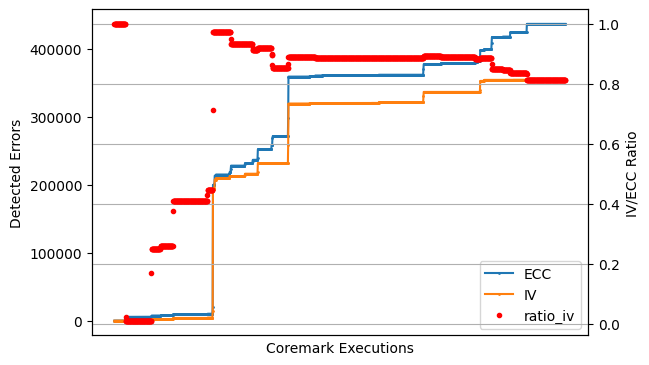

0.76 0.26


In [7]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[13][list_of_runs[13]['timestamp'].dt.day == 7]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(10,35)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(13,6)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

# filtered_df = filtered_df.loc[:, ['timestamp', 'imem_se', 'iv', 'imem_de', 'dsp_t']]
# filtered_df = filtered_df.drop_duplicates(subset=filtered_df.columns.difference(['timestamp']))

log_print.plot_imem_iv(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



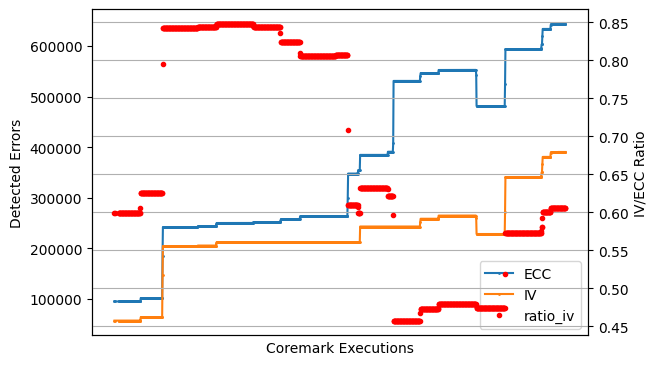

0.67 0.15


In [8]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[14][list_of_runs[14]['timestamp'].dt.day == 7]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(16,36)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(18,30)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

log_print.plot_imem_iv(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



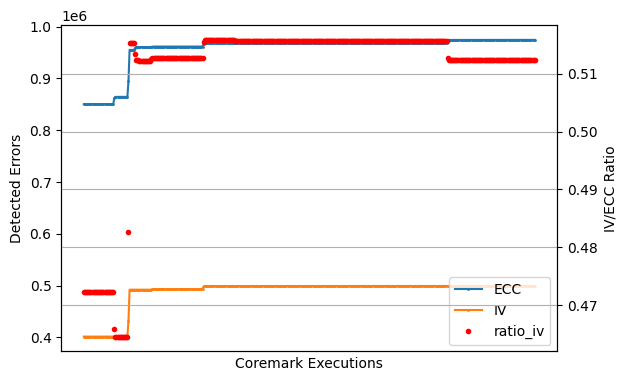

0.51 0.01


In [9]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[15][list_of_runs[15]['timestamp'].dt.day == 7]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(18,42)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(19,24)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

log_print.plot_imem_iv(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



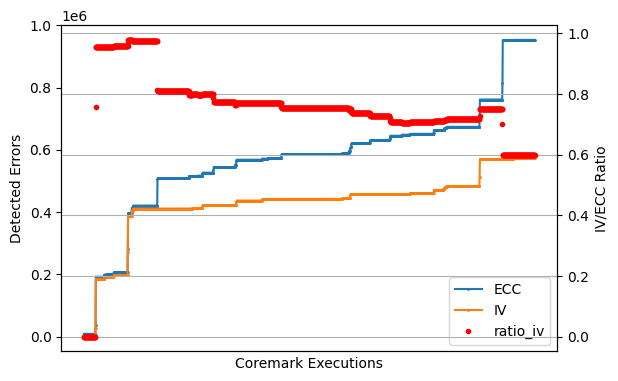

0.75 0.15


In [10]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[16][list_of_runs[16]['timestamp'].dt.day == 7]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(19,24)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(21,54)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

log_print.plot_imem_iv(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)



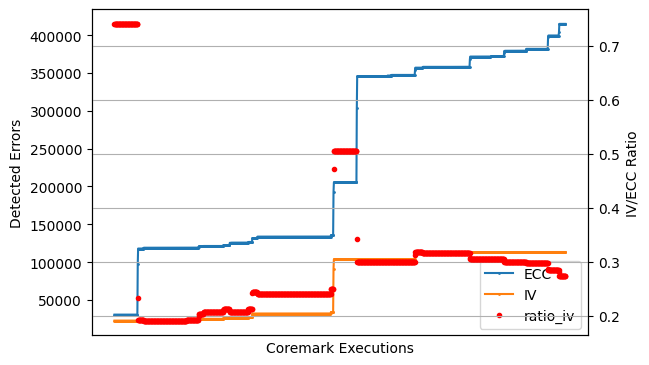

0.3 0.12


In [11]:

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

filtered_df = list_of_runs[21][list_of_runs[21]['timestamp'].dt.day == 8]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time > time(15,12)]
filtered_df = filtered_df[filtered_df['timestamp'].dt.time < time(17,6)]
filtered_df = filtered_df[filtered_df['imem_se'] > 0]

log_print.plot_imem_iv(filtered_df)

filtered_df["ratio_iv"] = filtered_df["iv"] / filtered_df["imem_se"]
filtered_df.loc[(filtered_df["iv"] == 0) & (filtered_df["imem_se"] == 0), "ratio_iv"] = 1

mean_ratio_iv = round(filtered_df['ratio_iv'].mean(), 2)
std_ratio_iv = round(filtered_df['ratio_iv'].std(), 2)

print(mean_ratio_iv, std_ratio_iv)

